# Image Compression & Re-Generation using a Vanilla Autoencoder

#### Author: Zubia Mansoor
#### Date: Oct 1, 2022
#### Event: Vancouver DataFest 2022

# Step 1: Import Packages

In [ ]:
##############################
# Some standard packages
##############################
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os

###############################
# Packages for deep learning
###############################
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchsummary import summary
import torchvision
from torchvision import datasets, transforms

###############################
# Additional
###############################
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# this is for using GPUs
# for calling multi-node GPUs, both won't be utilized unless we assign each GPU device explicitly as below
# device_0 = torch.device('cuda:0')
# device_1 = torch.device('cuda:1')


In [ ]:
# intialize parameters 
epochs = 10
batch_size = 16
torch.manual_seed(17)

# Step 2: Exploratory Data Analysis


In [ ]:
data_labels = pd.read_csv('train.csv')
print(f"The shape of the data is: {data_labels.shape}") # f-strings formatters are super handy!
data_labels.head()

Each row contains the pixel information of a specific image. Thus, looking at the shape of the data, we have  (1) 42,000 example images (2) each image is made up by 28x28 pixels





In [ ]:
data = data_labels.drop(['label'], axis=1) # we need only the pixel information since this is an unsupervised problem 
data.head()

In [ ]:
# take a random image (i.e. row)
index = 3
image= data.iloc[index]
image= np.array(image).astype('float32')

image = np.reshape(image, (28,28))
image = image/255 # normalize pixel values

In [ ]:
# visualise our data
plt.imshow(image, cmap = 'gray')
plt.title(f"Actual label: {data_labels.iloc[index,0]}") 
plt.show()

# Step 3: Data Preparation

In [ ]:
# Helper functions (usually, a good practice to have it in a separate helpers.py file)
def show_image(org_image, pred_image = None, latent_image = None):
    
    if pred_image == None:
        
        f, ax1 = plt.subplots(1, 1, figsize=(10,5))
        
        ax1.set_title('original_image')
        ax1.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
    else:
        
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))
        
        ax1.set_title('original_image')
        ax1.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('reconstructed_image')
        ax2.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('latent_image')
        ax3.imshow(latent_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
# converts an image to tensor         
class ToTensorForAE(object):
    
    def __call__(self,sample):
        
        images = sample
        
        images = images.transpose((2,0,1))
        return torch.from_numpy(images).float()

In [ ]:
# OOP way of programming is flexible, concise, efficient
class MNIST_AE_Dataset(Dataset):
  
  def __init__(self, data, transform):
    self.data = data
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    ## DIY!!!
    img =              # index data
    img =              # convert data into numpy array
    img =              # reshape to (height, width, num_channels) & normalize

    sample = img

    if self.transform:
      sample = self.transform(sample)
    return sample

In [ ]:
full_dataset = MNIST_AE_Dataset(data, transform = ToTensorForAE())
# create train/val splits
training_size = int(0.8 * len(full_dataset))
validation_size = int(0.2 * len(full_dataset))
training_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [training_size, validation_size])

In [ ]:
print(f"Size of training set: {len(training_dataset)}")
print(f"Size of training set: {len(validation_dataset)}")

In [ ]:
original_image = training_dataset[18]
show_image(org_image = original_image)

# Step 4: Creating Data Loaders

Dataloaders are used to load dataset into batches

In [ ]:
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataiter = iter(train_loader) # iterating through each item in the dataloader
original_image = dataiter.next()

print(f'Shape of loading one batch: {original_image.shape}') # 16: batch size, 1: no of channel(greyscale), (28,28): image size
print(f'Total no. of batches: {len(train_loader)}')
print(f'Total no. of examples: {len(train_loader)*batch_size}')

The dimensions correspond to (batch size, num of channels, height, width)

# Step 5: Auto Encoder Architecture

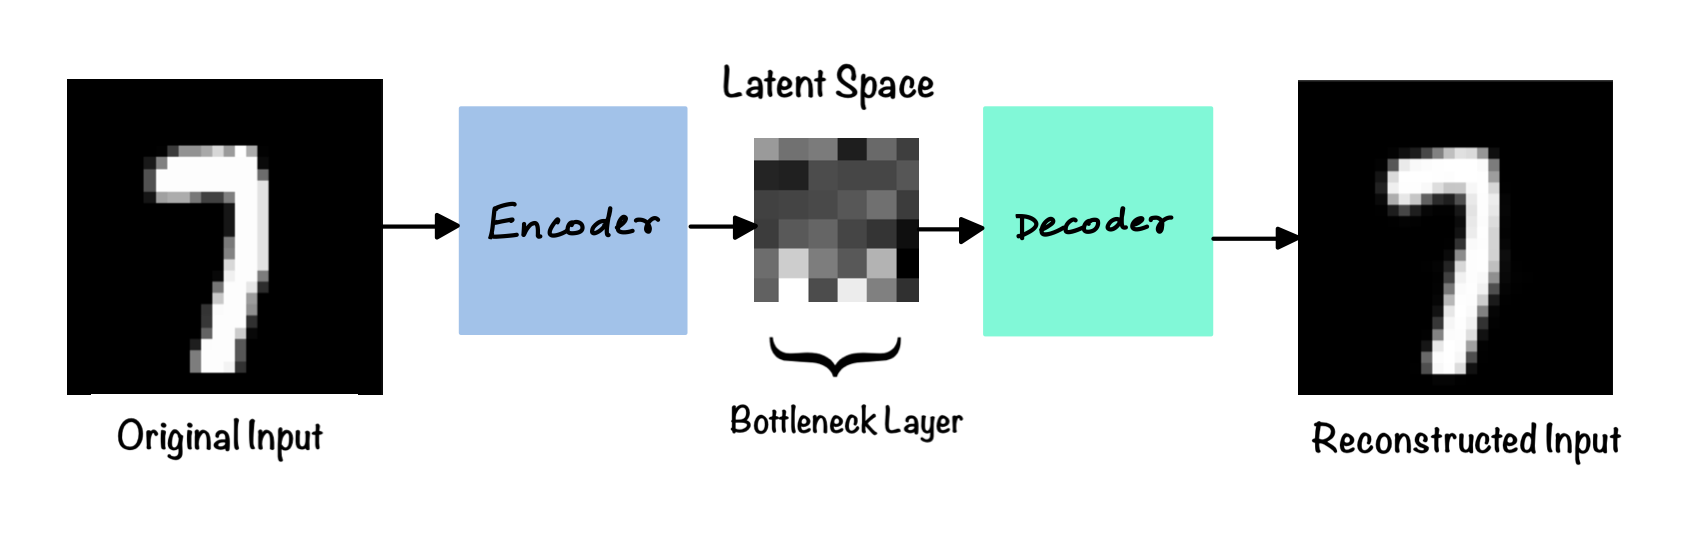

Note that we are building a linear (vanilla) autoencoder where the encoder and decoder consists of linear layers

Think of the autoencoder as an inverted hourglass and consider the encoding dimension to be an intermediate dimension between input & output which can be manipulated as per your need. Its size must stay between input & output dimensions!

In [ ]:
# skeleton for AE

# need to fill in dimensions here !!!
input_dim = 
hidden_space_dim = 
hidden_space_dim_2 = 
latent_space_dim = 

# build an encoder class
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # encoder has two hidden layers that deconstruct the input and one bottleneck layer (also called latent dimension) 
        self.en_h1 = nn.Linear(in_features = input_dim*input_dim, out_features = hidden_space_dim) # the idea is to bring down the size slowly before going into latent space
        self.en_h2 = nn.Linear(in_features = hidden_space_dim, out_features = hidden_space_dim_2)
        self.en_fc = nn.Linear(in_features = hidden_space_dim_2, out_features = latent_space_dim)
    
    # we apply a relu activation after the first and second hidden layers
    # encoded is the output from the bottleneck layer
    def forward(self,x):
        x = F.relu(self.en_h1(x))
        x = F.relu(self.en_h2(x))
        encoded =  self.en_fc(x)
        return encoded

# build a decoder class (DIY!!)    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        # decoders are mirror of your encoders, so it has two hidden layers that reconstruct output from latent dimension 
        # and an output layer
        self.de_h1 = 
        self.de_h2 = 
        self.de_fc =
    
    # use sigmoid activation so that output values lie between 0 and 1
    def forward(self,x):
        x =
        x = 
        decoded =  
        return decoded
    
# use the above two classes to construct an Auto Encoder            
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_x = self.encoder(x)
        output_x = self.decoder(latent_x)
        return latent_x, output_x 

In [ ]:
model = AE().to(device)
model

In [ ]:
summary(model, input_size = (1, 28*28))

In [ ]:
# define loss function -> binary cross-entropy (between reconstructed input and original input)
def loss_function(reconstructed_x, x): 
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, input_dim*input_dim), reduction='sum')
    return BCE 

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3) # can try different ones, keep default learning rate

# Step 6: Training Loop

In [ ]:
def evaluate(evaluate_data=val_loader):
    # this means that the model is in eval mode
    model.eval()
    val_loss = 0
    
    # we dont want to calculat gradients in eval mode
    with torch.no_grad():
      for data in evaluate_data:
          # print(f'before applying: {data.size()}')
          data = data.view(batch_size, -1)
          # print(f'after applying: {data.size()}')
          data = data.to(device)
          
          # this is the reconstructed output
          recon_batch = model(data)[1]
          # print(f'reconstructed output: {recon_batch.size()}')
          loss = loss_function(recon_batch, data)       
          val_loss += loss.item()
      
      average_val_loss = val_loss / len(evaluate_data.dataset)
      return average_val_loss

In [ ]:
def train(epoch):

    model.train()
    train_loss = 0
    
    progress_bar = tqdm(train_loader, desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)
    for data in progress_bar:
        # print(f'before applying: {data.size()}')
        data = data.view(batch_size, -1)
        # print(f'after applying: {data.size()}')
        data = data.to(device)
        
        # set gradients to 0
        optimizer.zero_grad()
        
        # this is the reconstructed output
        recon_batch = model(data)[1]
        # print(f'reconstructed output: {recon_batch.size()}')
        loss = loss_function(recon_batch, data)
        
        # in train mode, we do want to calculate gradients
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_loader.dataset)
    tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))
    val_loss = evaluate(val_loader)
    tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))

    # lists that contain the losses
    train_losses.append(average_train_loss)
    val_losses.append(val_loss)
    
    # every epoch, save our model state dictionary that contain all the layers, 
    # their weights, biases to load in a fresh model
    if epoch%1==0:
        torch.save(model.state_dict(), f'Models/epoch_{epoch}.model')

In [ ]:
train_losses = []
val_losses = []
os.mkdir('Models') # comment out once folder is created
for epoch in range(1, epochs+1):
  train(epoch)
    
np.savetxt('Models/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt('Models/validation_losses.txt', np.array(val_losses), delimiter='\n')

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(train_losses, label='Train')
plt.semilogy(val_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

# Step 7: Results 

In [ ]:
test_data = pd.read_csv('test.csv')
print(f"The shape of the data is: {test_data.shape}")

In [ ]:
# prep test data
test_dataset = MNIST_AE_Dataset(test_data, transform = ToTensorForAE())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model.eval()

with torch.no_grad():
  
  # test data
  dataiter = iter(test_loader)
  sample = dataiter.next()

  index = 4

  original_image = sample

  # this is the latent and reconstructed output
  latent_image, reconstructed_image = model(original_image[index].view(1,-1)) # model takes input as (batch_size, num_features)
  reconstructed_image = np.reshape(reconstructed_image, (1,28,28))
  latent_image = np.reshape(latent_image, (1,6,6))

  print(f"Shape of original image: {original_image[index].view(1,-1).shape}")
  print(f"Shape of reconstructed image: {reconstructed_image.shape}")
  print(f"Shape of latent image: {latent_image.shape}")
  show_image(original_image[index], reconstructed_image, latent_image) 
  

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
sample = dataiter.next()

original_image = sample

images_flatten = original_image.view(original_image.size(0), -1)
# get sample outputs
output = model(images_flatten)[1]
# prep images for display
images = original_image.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
print('Original versus Reconstructed Image')
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)



# Step 8: Visualize the Latent Space 

In [ ]:
test_dataset  = torchvision.datasets.MNIST('dataset', train=False, download=True)
test_transform = transforms.Compose([
transforms.ToTensor(),
])
test_dataset.transform = test_transform

In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model(img.view(1,-1))[0]
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()
